 # Llamamos a las librerias necesarias
 


In [201]:
import os
import tarfile
import urllib.request
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
import joblib
from joblib import dump
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import joblib
import json
from sklearn.model_selection import GridSearchCV

Obtendremos la base de datos en formatos tgz y cvs 


In [9]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

In [15]:
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [13]:
fetch_housing_data()

Se crera una funcion llamada load_housing_data para mandar llamar a la base de datos, despues llamaremos "housing" a esa base datos dentro de nuestro codigo 

In [18]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [21]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [24]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [26]:
housing.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [28]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


## Vamos a dividir los datos en 80% para entrenar el modelo y 20% para pruebas, esto se hara de manera aleatoria

In [34]:
def split_train_test(data,test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data)*test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices],data.iloc[test_indices]

In [36]:
train_set, test_set = split_train_test(housing,0.2)

In [38]:
len(train_set)

16512

In [40]:
len(test_set)

4128

In [44]:
housing["income_cat"] = pd.cut(housing["median_income"],bins=[0.,1.5,3.0,4.5,6.,np.inf],labels=[1,2,3,4,5])

<Axes: >

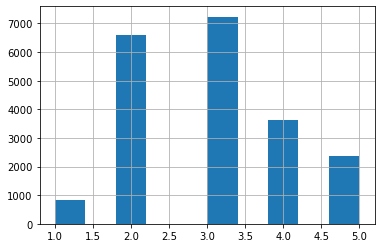

In [46]:
housing["income_cat"].hist()

<Axes: >

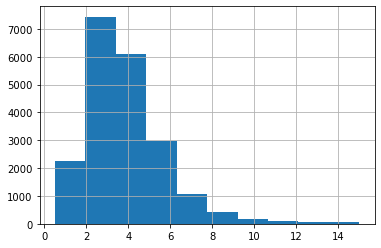

In [48]:
housing["median_income"].hist()

## Vamos a estratificar los datos para un mejor resultado

In [53]:
split = StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)
for train_index, test_index in split.split(housing,housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [55]:
for set_ in (strat_train_set,strat_test_set):
    set_.drop("income_cat",axis=1,inplace=True)

Haremos una copia de la base de datos para no modificarla

In [58]:
housing = strat_test_set.copy()

<Axes: xlabel='longitude', ylabel='latitude'>

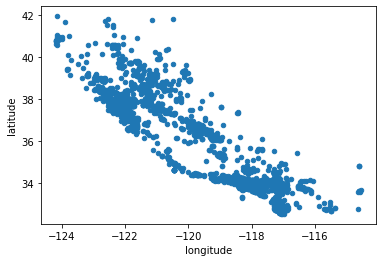

In [60]:
housing.plot(kind="scatter",x="longitude",y="latitude")

<Axes: xlabel='longitude', ylabel='latitude'>

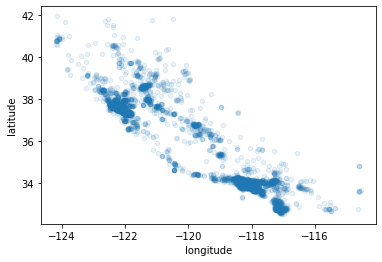

In [62]:
housing.plot(kind="scatter",x="longitude",y="latitude", alpha=0.1)

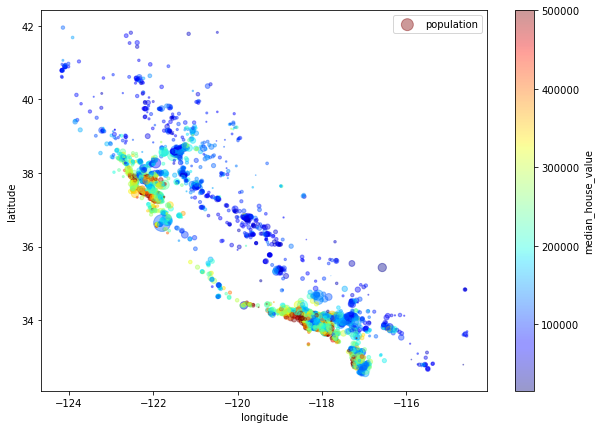

In [66]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=housing["population"]/100, label="population", figsize=(10,7),
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
             sharex=False)
plt.legend()
#vamos a visualizar la geografia por precio mediano

## Haremos una matriz de correlacion para entender mejor los datos

In [69]:
numeric_housing = housing.select_dtypes(include=['number'])
corr_matrix = numeric_housing.corr()

In [71]:
corr_matrix["median_house_value"].sort_values(ascending=False)##correlación de las diferentes features con median house value


median_house_value    1.000000
median_income         0.691867
total_rooms           0.131296
housing_median_age    0.071210
households            0.070947
total_bedrooms        0.057247
population           -0.016164
longitude            -0.039848
latitude             -0.150336
Name: median_house_value, dtype: float64

array([[<Axes: xlabel='median_house_value', ylabel='median_house_value'>,
        <Axes: xlabel='median_income', ylabel='median_house_value'>,
        <Axes: xlabel='total_rooms', ylabel='median_house_value'>,
        <Axes: xlabel='housing_median_age', ylabel='median_house_value'>],
       [<Axes: xlabel='median_house_value', ylabel='median_income'>,
        <Axes: xlabel='median_income', ylabel='median_income'>,
        <Axes: xlabel='total_rooms', ylabel='median_income'>,
        <Axes: xlabel='housing_median_age', ylabel='median_income'>],
       [<Axes: xlabel='median_house_value', ylabel='total_rooms'>,
        <Axes: xlabel='median_income', ylabel='total_rooms'>,
        <Axes: xlabel='total_rooms', ylabel='total_rooms'>,
        <Axes: xlabel='housing_median_age', ylabel='total_rooms'>],
       [<Axes: xlabel='median_house_value', ylabel='housing_median_age'>,
        <Axes: xlabel='median_income', ylabel='housing_median_age'>,
        <Axes: xlabel='total_rooms', ylabel='housi

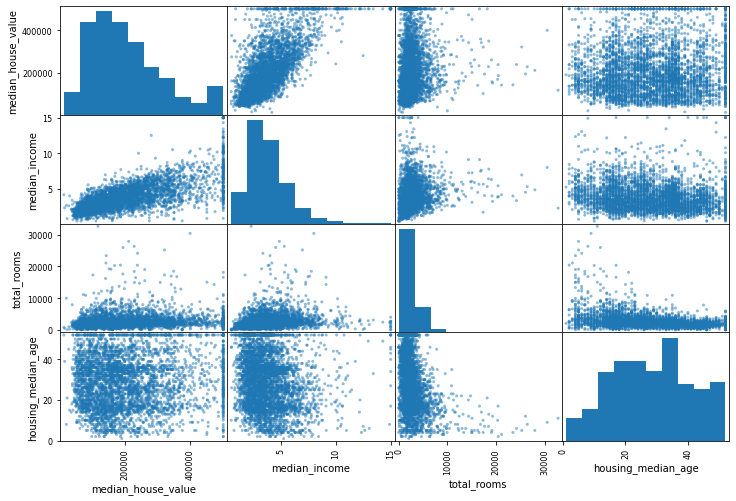

In [77]:
attributes = ["median_house_value","median_income","total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes],figsize=(12,8))

In [79]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"] = housing["population"]/housing["households"]

In [82]:
numeric_housing = housing.select_dtypes(include=['number'])
corr_matrix = numeric_housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.691867
rooms_per_household         0.192731
total_rooms                 0.131296
housing_median_age          0.071210
households                  0.070947
total_bedrooms              0.057247
population                 -0.016164
longitude                  -0.039848
population_per_household   -0.134999
latitude                   -0.150336
bedrooms_per_room          -0.240481
Name: median_house_value, dtype: float64

In [84]:
housing = strat_train_set.drop("median_house_value",axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [86]:
#housing.dropna(subset=["total_bedrooms"])
#housing.drop("total_bedrooms",axis =1)
housing.dropna(subset=["total_bedrooms"])
housing.drop("total_bedrooms",axis =1)
median = housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median,inplace=True)

C:\Users\torre\AppData\Local\Temp\ipykernel_5024\3285498441.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  housing["total_bedrooms"].fillna(median,inplace=True)


In [88]:
from sklearn.impute import SimpleImputer

In [90]:
imputer = SimpleImputer(strategy ="median")
housing_num = housing.drop("ocean_proximity",axis =1)
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [92]:
imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [94]:
housing_num.median().values

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [96]:
x = imputer.transform(housing_num)

In [98]:
housing_tr = pd.DataFrame(x,columns=housing_num.columns,index=housing_num.index)


In [100]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN
1481,NEAR BAY
18125,<1H OCEAN
5830,<1H OCEAN
17989,<1H OCEAN
4861,<1H OCEAN


In [106]:
ordinal_encoder = OrdinalEncoder()

In [108]:
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]##codificar datos categóricos a datos numéricos

array([[1.],
       [4.],
       [1.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [110]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

## se van a transformar los datos en arreglos binarios

In [115]:
cat_encoder = OneHotEncoder()

In [117]:
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [119]:
housing_cat_1hot.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [125]:
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

vamos a agregar nuevas categorias

In [128]:
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

## Transformers pipelines
### haremos flujos de trabajos para tranformar y estimar todo el conjunto de datos manejado


In [135]:
num_pipeline = Pipeline([
              ('imputer',SimpleImputer(strategy="median")),
              ('attribs_adder',CombinedAttributesAdder()),
              ('std_scaler',StandardScaler())
              ])
housing_num_tr = num_pipeline.fit_transform(housing_num)
num_pipeline

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('attribs_adder', CombinedAttributesAdder()),
                ('std_scaler', StandardScaler())])

## Transformer
### con esto vamos a poder manejar los datos numericos con los categoricos 

In [140]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

In [142]:
num_attribs

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income']

In [144]:
full_pipeline = ColumnTransformer([
                 ("num",num_pipeline,num_attribs),
                 ("cat",OneHotEncoder(),cat_attribs)
              ])
housing_prepared = full_pipeline.fit_transform(housing)
full_pipeline

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('attribs_adder',
                                                  CombinedAttributesAdder()),
                                                 ('std_scaler',
                                                  StandardScaler())]),
                                 ['longitude', 'latitude', 'housing_median_age',
                                  'total_rooms', 'total_bedrooms', 'population',
                                  'households', 'median_income']),
                                ('cat', OneHotEncoder(), ['ocean_proximity'])])

In [150]:
dump(full_pipeline,'pipeline.sav')

['pipeline.sav']

In [152]:
housing_prepared

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.26758118, -0.1259716 ,  1.22045984, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ...,  0.        ,
         0.        ,  0.        ],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.        ,
         0.        ,  0.        ]])

## Usando regresion lineal, decision tree y random forrest vamos a validar el modelo

In [157]:
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared,housing_labels)

LinearRegression()

### Se toman del trainset y se preparan en el pipeline, para realizar prediccion

In [160]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("predcitions: " ,lin_reg.predict(some_data_prepared))
print("labels: ", list(some_labels))

predcitions:  [ 85657.90192014 305492.60737488 152056.46122456 186095.70946094
 244550.67966089]
labels:  [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


## Usaremos el Mean square error, esta es ka diferencia entre el estimador y lo que se estima

In [163]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels,housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68627.87390018745

## Cross-validation 
### Dividiremos el trainset en 10, luegoo se evaluaran de manera aleatoria. Con esto tendremos un valor estimado del rendimiento del modelo entrenado y que tan preciso es la estimacion

In [168]:
lin_scores = cross_val_score(lin_reg,housing_prepared,housing_labels,
                             scoring="neg_mean_squared_error",cv=10)

In [194]:
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores=(lin_rmse_scores)
display_scores

array([71762.76364394, 64114.99166359, 67771.17124356, 68635.19072082,
       66846.14089488, 72528.03725385, 73997.08050233, 68802.33629334,
       66443.28836884, 70139.79923956])

## Por medio de GRID SEARCH vamos a darle FINE TUNNING al modelo
### Este metodo busca los mejores parametros que requiere nuestro modelo. Con esto se prueba con mayor seguridad el training set y asi tener mejores predicciones y medidad del error

In [203]:
X_test = strat_test_set.drop("median_house_value",axis=1)
y_test = strat_test_set["median_house_value"].copy()

In [205]:
X_test_prepared = full_pipeline.transform(X_test)


### Grid search con regresion lineal

In [208]:
lin_reg = LinearRegression()

In [210]:
param_grid = [{"fit_intercept": [False],"positive":[True,False],"copy_X":[False],"n_jobs":[None,-1]}]

In [212]:
grid_search = GridSearchCV(lin_reg,param_grid,cv=10,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

In [214]:
grid_search.fit(housing_prepared ,housing_labels)

GridSearchCV(cv=10, estimator=LinearRegression(),
             param_grid=[{'copy_X': [False], 'fit_intercept': [False],
                          'n_jobs': [None, -1], 'positive': [True, False]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [216]:
grid_search.best_estimator_

LinearRegression(copy_X=False, fit_intercept=False)

In [218]:
grid_search.best_params_

{'copy_X': False, 'fit_intercept': False, 'n_jobs': None, 'positive': False}

In [220]:
cvres = grid_search.cv_results_

In [222]:
for mean_score, params in zip(cvres["mean_test_score"],cvres["params"]):
    print(np.sqrt(-mean_score),params)

72585.39599194018 {'copy_X': False, 'fit_intercept': False, 'n_jobs': None, 'positive': True}
69164.08143552528 {'copy_X': False, 'fit_intercept': False, 'n_jobs': None, 'positive': False}
72585.39599194018 {'copy_X': False, 'fit_intercept': False, 'n_jobs': -1, 'positive': True}
69164.08143552528 {'copy_X': False, 'fit_intercept': False, 'n_jobs': -1, 'positive': False}


In [224]:
final_modelLR = grid_search.best_estimator_

In [226]:
final_modelLR

LinearRegression(copy_X=False, fit_intercept=False)

In [228]:
final_predictions_LR = final_modelLR.predict(X_test_prepared)

In [230]:
final_predictions_LR

array([424327.43173199, 290941.55056488, 242611.08936427, ...,
       309892.89406352, 266770.06617997, 238676.55345928])

In [232]:
final_mse_LR = mean_squared_error(y_test,final_predictions_LR)

In [234]:
final_mse_LR

4477408708.672434

In [236]:
final_rmse_LR=np.sqrt(final_mse_LR)

In [238]:
final_rmse_LR

66913.44191320929

In [240]:
dump(final_modelLR,'modelLR.sav')

['modelLR.sav']